# Settings

In [1]:
import sys
import os

os.chdir('..')
os.getcwd()

'c:\\Users\\adagi\\Documents\\GitHub\\ANLP-Project'

# Imports

In [2]:
#! pip install editdistance
#! pip install num2words

In [3]:
from scripts.model import device, CharBiLSTM
from scripts.data import create_data_loader, load_data
from scripts.preprocessing import get_typoglycemia_modified_data, sentence_tokennizer, tokenize_dataframe, get_max_length
from scripts.baseline import get_base_line_score

from torch import nn, optim
import torch

from sklearn.model_selection import train_test_split

import editdistance
#from tqdm import tqdm
# from tqdm.notebook import tqdm
from tqdm.autonotebook import trange, tqdm
import random 

from sklearn.metrics import f1_score, accuracy_score
import numpy as np



import pandas as pd
import matplotlib.pyplot as plt
random.seed(42)
torch.manual_seed(42);

device

c:\Users\adagi\Documents\GitHub\ANLP-Project\scripts\preprocessing.py:55: SyntaxWarning: invalid escape sequence '\s'
  x = re.sub('[^a-zA-Z\s\.]', '', x)
c:\Users\adagi\Documents\GitHub\ANLP-Project\scripts\preprocessing.py:57: SyntaxWarning: invalid escape sequence '\.'
  x = re.sub('\.{2,}', ' ', x)
c:\Users\adagi\Documents\GitHub\ANLP-Project\scripts\preprocessing.py:61: SyntaxWarning: invalid escape sequence '\s'
  x = x = re.sub('\s{2,}', ' ', x)
C:\Users\adagi\AppData\Local\Temp\ipykernel_12652\2117565946.py:14: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange, tqdm


device(type='cpu')

# Data

In [83]:
df_hard = load_data(file_path = "data/processed/sscorpus_hard.csv")
df_easy = load_data(file_path = "data/processed/sscorpus_easy.csv")
df_hard = df_hard[~df_hard['typoglycemia'].isna()]
df_easy = df_easy[~df_easy['typoglycemia'].isna()]
#rename columns such that they match the earlier written code
df_hard = df_hard.rename(columns={'typoglycemia': 'Hard_Typo', 'split':'Hard'})
df_easy = df_easy.rename(columns={'typoglycemia': 'Easy_Typo', 'split':'Easy'})
#df = df[(~df['Hard_Typo'].isna()) & (~df['Easy_Typo'].isna())]




In [84]:
df_hard.head(3)

,original,Hard,Hard_Typo
0,on the Dover Air Force Base .on the Dover Air ...,on the Dover Air Force Base,on the Dvoer Air Fcroe Bsae
1,in games including `` Super Smash Bros. '' and...,in games including Super Smash Bros,in geams iuilcnndg Seupr Samsh Bors
2,in games including `` Super Smash Bros. '' and...,and,and


In [85]:
df_easy.head(3)

,original,Easy,Easy_Typo
0,It ends near the Dover Air Force Base and DE 1...,It ends near the Dover Air Force Base and DE c...,It ends near the Deovr Air Fcroe Base and DE c...
1,He has been in a number of video games includi...,He has been in a number of video games includi...,He has been in a nuebmr of veido gemas icluind...
2,He has been in a number of video games includi...,Kirby s Dream Land and,Kibry s Darem Lnad and


## Splitting data into train, val, test

In [86]:
#Hard data
dev_hard, test_hard = train_test_split(df_hard, test_size=0.2)
train_hard, validation_hard = train_test_split(dev_hard, test_size=0.2)
#easy 
dev_easy, test_easy = train_test_split(df_easy, test_size=0.2)
train_easy, validation_easy = train_test_split(dev_easy, test_size=0.2)

## Baseline dev

In [87]:
# Get baseline easy 
get_base_line_score(train = train_easy, test = test_easy, type = 'Easy')

The base line has a mean editdistance of 0.263 pr. sentence, and 0.283 pr. word


In [88]:
get_base_line_score(train = train_hard, test = test_hard, type = 'Hard')

The base line has a mean editdistance of 0.288 pr. sentence, and 0.301 pr. word


## Getting dataloaders

In [89]:
complexity_level = "Hard"

In [90]:
train_hard = tokenize_dataframe(train_hard, complexity_level)
validation_hard = tokenize_dataframe(validation_hard, complexity_level)
test_hard = tokenize_dataframe(test_hard, complexity_level)

In [91]:
combined_text_hard = ' '.join(train_hard["Hard_Typo"])
unique_characters_hard = set(combined_text_hard)
vocabulary_size_hard = len(unique_characters_hard)
vocabulary_size_hard

27

Five-number summary: Min: 0, Q1: 67.0, Median: 103.0, Q3: 148.0, Max: 1249
Mean: 113.13317161916314, Std Dev: 66.64432789792455


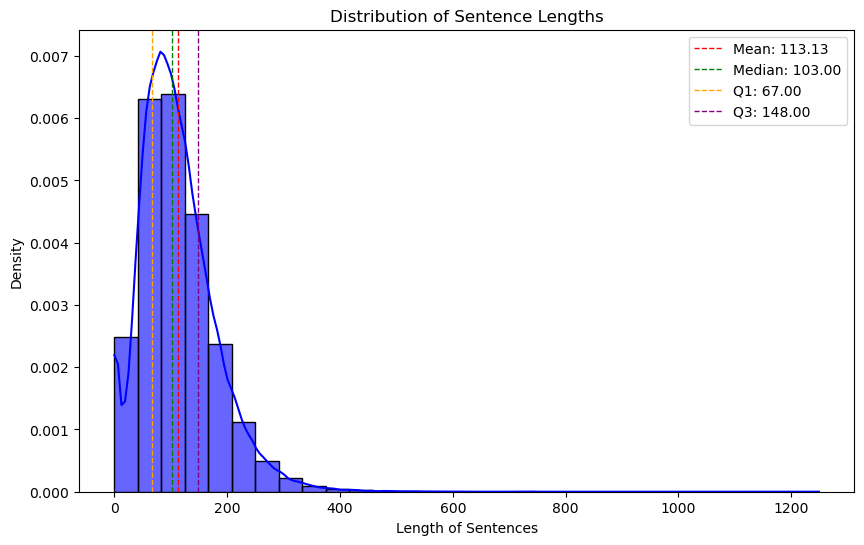

Five-number summary: Min: 0, Q1: 67.0, Median: 104.0, Q3: 148.0, Max: 739
Mean: 113.24575970742448, Std Dev: 66.62842234480735


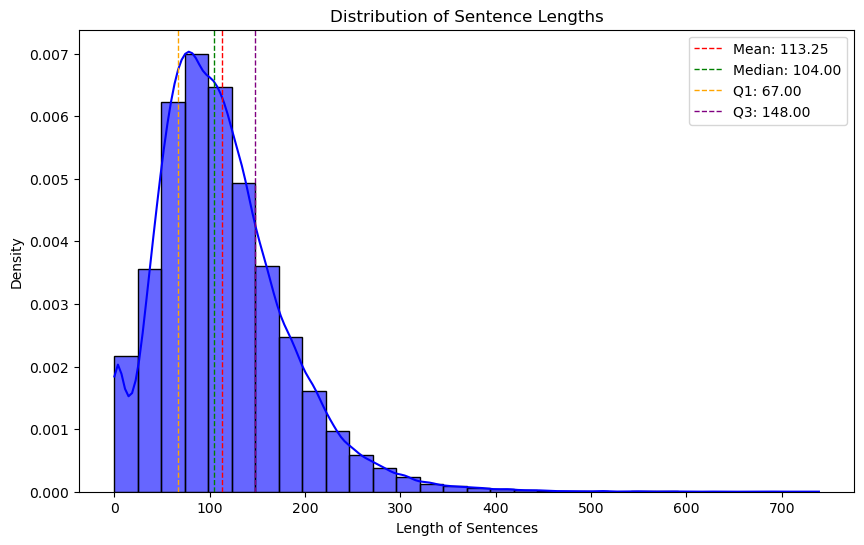

Five-number summary: Min: 0, Q1: 68.0, Median: 104.0, Q3: 149.0, Max: 824
Mean: 113.56640444238778, Std Dev: 66.2429947438163


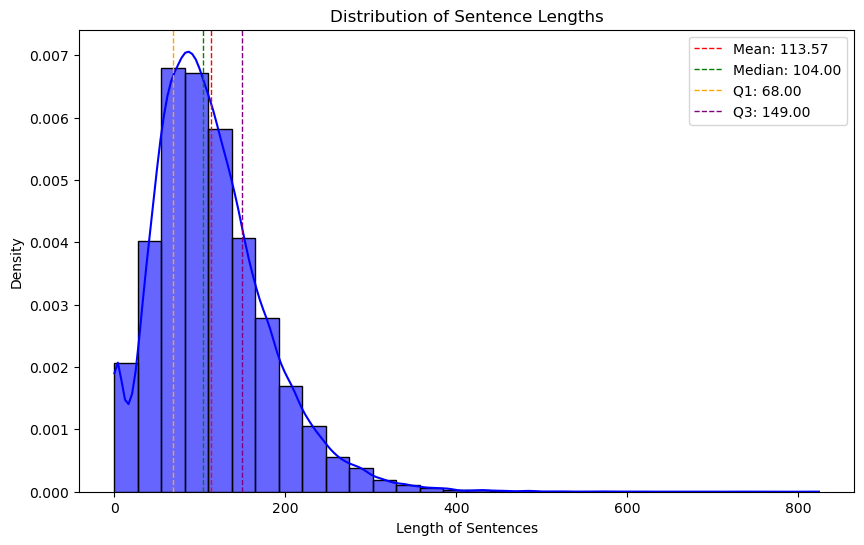

In [92]:
max_length_train_hard = get_max_length(train_hard, complexity_level)
max_length_validation_hard = get_max_length(validation_hard, complexity_level)
max_length_test_hard = get_max_length(test_hard, complexity_level)

In [93]:
max_length_hard = max([max_length_train_hard, max_length_validation_hard, max_length_test_hard])
max_length_hard=300
max_length_hard

300

In [94]:
all_sentences_hard = pd.concat([df_hard[complexity_level], df_hard[complexity_level + "_Typo"]])
lengths_hard = all_sentences_hard.str.len()
lengths_hard

0          28
1          35
2           5
3          50
4          20
         ... 
334949     33
334950     92
334951    224
334952     50
334953     84
Length: 669908, dtype: int64

In [95]:
batch_size = 2**8
# batch_size = 2

In [58]:
train_loader_hard = create_data_loader(train_hard, complexity=complexity_level, max_length=max_length_hard, batch_size=batch_size) # TODO 
validation_loader_hard = create_data_loader(validation_hard, complexity=complexity_level, max_length=max_length_hard, batch_size=batch_size) # TODO 
test_loader_hard = create_data_loader(test_hard, complexity=complexity_level, max_length=max_length_hard, batch_size=batch_size) # TODO 

In [59]:
for sample in train_loader_hard:
    X, y = sample
    print(X.shape, y.shape)
    print(np.unique(y.cpu(), return_counts=True))
    break

torch.Size([256, 300]) torch.Size([256, 300])
(array([-1,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26], dtype=int64), array([46996,  2193,   420,   830,   965,  2914,   560,   493,  1281,
        1986,    61,   162,  1076,   613,  1981,  1799,   477,    22,
        1564,  1620,  2157,   650,   241,   410,    43,   372,  4914],
      dtype=int64))


In [60]:
ord('a') - ord('a') + 1

1

# Model  (Not finished just a template)

In [61]:
input_size = vocabulary_size_hard 
input_size = 1  # Uses the raw index in alphabet as input
hidden_size = 2**6 # Maps to hidden size
output_size = vocabulary_size_hard +  1  # Outputs probabilities for each character in vocabulary + padding
num_layers = 1   

model = CharBiLSTM(input_size, hidden_size, output_size, num_layers, max_length_hard, batch_size).to(device)
loss_function = nn.CrossEntropyLoss(ignore_index=-1).to(device) # Padding is value -1, therefore we want to ignore it in our loss function
optimizer = optim.Adam(model.parameters(), lr=0.02, amsgrad=True)

epochs = 3

# Training

In [62]:
val_loss_dc = {}
train_loss_dc = {}

for epoch in tqdm(range(epochs), position=0):
    model.train()
    epoch_loss = 0.0    
    for batch in tqdm(train_loader_hard, position=1, leave=False):
        typo_batch, sentence_batch = batch  
        
        sentence_batch = sentence_batch.view(-1)
        typo_batch = typo_batch.reshape(-1, max_length_hard, 1)

        y = model.forward(typo_batch, train=False)  
        loss = loss_function(y, sentence_batch)  
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()

    epoch_loss_avg = epoch_loss / len(train_loader_hard)
    train_loss_dc[epoch] = epoch_loss_avg

    model.eval()
    val_loss = 0.0
    with torch.no_grad():  
        for val_batch in tqdm(validation_loader_hard, position=2, leave=False):
            typo_val_batch, sentence_val_batch = val_batch
            
            sentence_val_batch = sentence_val_batch.view(-1)
            typo_val_batch = typo_val_batch.reshape(-1, max_length_hard, 1)
            
            val_y = model.forward(typo_val_batch, train=False)
            
            val_loss_batch = loss_function(val_y, sentence_val_batch)
            val_loss += val_loss_batch.item()
                
    val_loss_avg = val_loss / len(validation_loader_hard)
    val_loss_dc[epoch] = val_loss_avg
    
    print(f"Epoch {epoch + 1}/{epochs} Train Loss: {epoch_loss_avg:.8f} Val Loss: {val_loss_avg:.8f}")

  0%|          | 0/3 [01:54<?, ?it/s]


KeyboardInterrupt: 

Text(0, 0.5, 'Cross Entropy Loss')

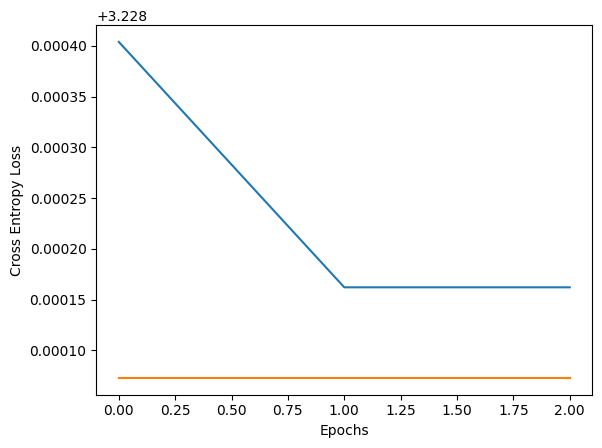

In [38]:
plt.plot(train_loss_dc.keys(), train_loss_dc.values(), label="Train Loss")
plt.plot(val_loss_dc.keys(), val_loss_dc.values(), label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")

# Evaluation

In [39]:
def index_to_char(index, target = True):
    if target == False:
        index = index*100
    index = int(index)
    if 1 <= index <= 25:
        return chr(index + ord('a') - 1)
    elif index == 26:
        return ' '
    else:
        return "_"  # for all other values, return None

In [40]:
import csv

def get_metrics(loader, model, loader_str, output_file="output.csv", sample_size=10):
    preds = []
    labels = []
    inputs = []  # To store input sequences
    
    model.eval()
    loss = 0.0
    csv_data = [["Input Word", "Label Word", "Predicted Word"]]  # CSV header
    sentence_label = []
    sentence_pred = []
    sentence_input = []  # To store input words
    word_label = []
    word_pred = []
    word_input = []

    with torch.no_grad():
        for batch in tqdm(loader, position=3, leave=False):
            typo_batch, sentence_batch = batch  # typo_batch is the input, sentence_batch is the target sequence

            # Reshape inputs for model and get predictions
            sentence_batch = sentence_batch.view(-1)
            typo_batch = typo_batch.reshape(-1, max_length, 1)
            y = model.forward(typo_batch, train=False)  # y should be shape (batch_size, seq_len, vocab_size)
            
            # Calculate and accumulate loss
            loss_batch = loss_function(y, sentence_batch)
            loss += loss_batch.item()
            
            # Get predictions, labels, and inputs in a flattened form
            batch_preds = torch.argmax(y, dim=1).cpu().numpy().reshape(-1)
            batch_labels = sentence_batch.cpu().numpy().reshape(-1)
            batch_inputs = typo_batch.cpu().numpy().reshape(-1)
            
            # Append these results for later accuracy and F1 calculations
            preds.extend(batch_preds)
            labels.extend(batch_labels)
            inputs.extend(batch_inputs)
            
            # Process each element in the batch
            for label_idx in range(len(batch_preds)):
                label_char = index_to_char(batch_labels[label_idx])
                pred_char = index_to_char(batch_preds[label_idx])
                input_char = index_to_char(batch_inputs[label_idx],target = False)
                
                # Ignore padding characters
                if label_char != "_":
                    word_label.append(label_char)
                if pred_char != "_":
                    word_pred.append(pred_char)
                if input_char != "_":
                    word_input.append(input_char)
                
                # If end of a word (detected by space), append word to csv_data
                if label_char == " ":
                    # Join and append the completed word to csv data
                    csv_data.append(["".join(word_input), "".join(word_label), "".join(word_pred)])
                    # Clear the lists for the next word
                    word_label = []
                    word_pred = []
                    word_input = []
                
    # Write data to CSV file
    with open(output_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerows(csv_data)
    
    # Display a subset of rows in the old format for console output
    print(f"\nDisplaying the first {sample_size} rows from the output file:\n")
    print("Input Word      | Label Word      | Predicted Word")
    print("-" * 50)
    for row in csv_data[1:sample_size + 1]:  # Skip header row, take only `sample_size` rows
        print(f"{row[0]:<15} | {row[1]:<15} | {row[2]}")
    
    # Compute and display metrics
    loss_avg = loss / len(loader)
    print(f"\n{loader_str} Loss: {loss_avg:.4f}")
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    
    print(f"\n{loader_str} Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")


In [41]:
n_print = 100

In [42]:
get_metrics(train_loader, model, "train", "train_predictions.csv", n_print)

  0%|          | 0/1233 [00:00<?, ?it/s]


Displaying the first 100 rows from the output file:

Input Word      | Label Word      | Predicted Word
--------------------------------------------------
otrerneecy      | presented       |           
ayy             | by              |    
rnerbijry       | snickers        |          
brngebtry       | cruncher        |          
ity             | it              |    
toojy           | took            |      
okbey           | place           |       
ony             | on              |    
oirky           | april           |       
ty              | at              |    
tgey            | the             |     
rkniety         | reliant         |         
rotclroey       | astrodome       |           
iny             | in              |    
gottorny        | houston         |         
twertgey        | texasthe        |                                                                                                                                                                    

In [ ]:
get_metrics(validation_loader, model, "validation", "validation_predictions.csv", n_print)

In [ ]:
get_metrics(test_loader, model, "test", "test_predictions.csv", n_print)